In [1]:
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
%matplotlib inline 

import cv2

from skimage.io import imread
from skimage import color

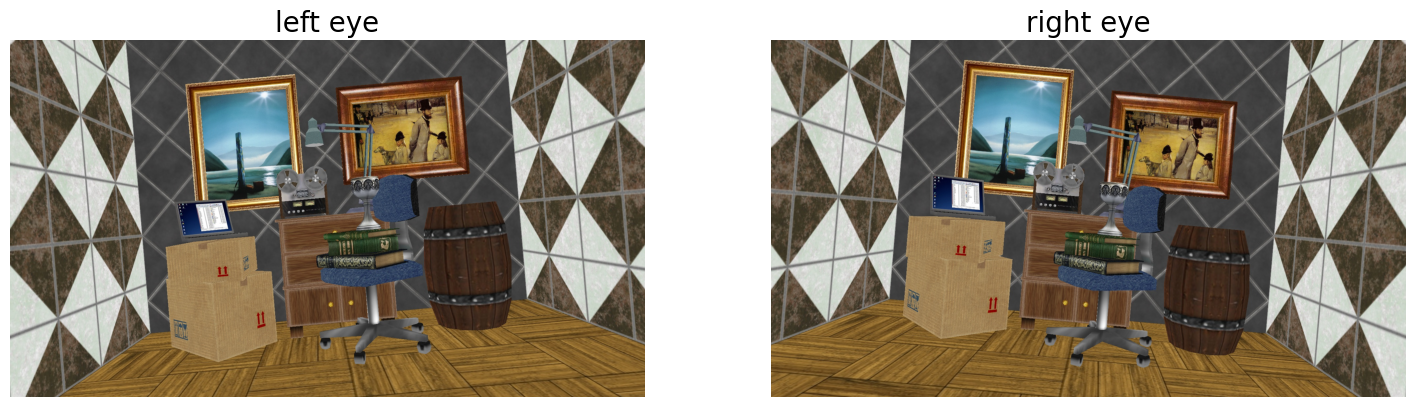

In [2]:
# images from Hyunsuk Ko
# https://mcl.usc.edu/mcl-ss-database/

left = imread('set1_L_zrotation.jpg')
right = imread('set1_R_zrotation.jpg')

plt.figure(figsize=(18,11))

plt.subplot(121)
plt.imshow(left)
plt.axis('off')
plt.title('left eye', fontsize=20)

plt.subplot(122)
plt.imshow(right)
plt.axis('off')
plt.title('right eye', fontsize=20)

plt.show()

## we want to determine the fundamental matrix so we search for matching points

In [3]:
# find the keypoints and descriptors with SIFT
descriptor = cv2.SIFT_create()

left_g = np.uint8(color.rgb2gray(left)*255)
kp_left, des_left = descriptor.detectAndCompute(left_g, None)

right_g = np.uint8(color.rgb2gray(right)*255)
kp_right, des_right = descriptor.detectAndCompute(right_g, None)

In [4]:
# find matches 
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des_left,des_right,k=2)

In [5]:
# ratio test as per Lowe's criterion
ratio = 0.7 # distance threshold between first and second best match

pts1 = []
pts2 = []
good_matches = []

for i,(best,second) in enumerate(matches):
    if best.distance < ratio *second.distance:
        print(best.distance, second.distance)
        pts2.append(kp_right[best.trainIdx].pt)
        pts1.append(kp_left[best.queryIdx].pt)
        good_matches.append(best)

66.73080444335938 250.5972900390625
50.93132781982422 85.7787857055664
99.37806701660156 160.85086059570312
106.58329772949219 254.02755737304688
90.21086120605469 306.572998046875
95.02104949951172 298.8745422363281
65.57438659667969 326.5838317871094
110.5169677734375 180.44943237304688
89.8276138305664 328.4052429199219
133.7572479248047 354.5588684082031
110.70681762695312 325.0415344238281
112.1383056640625 330.3468017578125
48.754486083984375 121.14866638183594
167.3170623779297 293.0238952636719
169.59657287597656 365.58172607421875
43.874820709228516 106.92520904541016
122.95934295654297 275.6990966796875
133.0300750732422 307.7742614746094
66.22688293457031 259.9346008300781
85.83705139160156 330.9773254394531
102.67911529541016 299.84661865234375
137.23338317871094 316.0870056152344
146.21217346191406 349.87713623046875
93.88290405273438 335.1343078613281
137.88400268554688 344.8811340332031
93.16114807128906 393.614013671875
99.9699935913086 228.87551879882812
111.6512451171

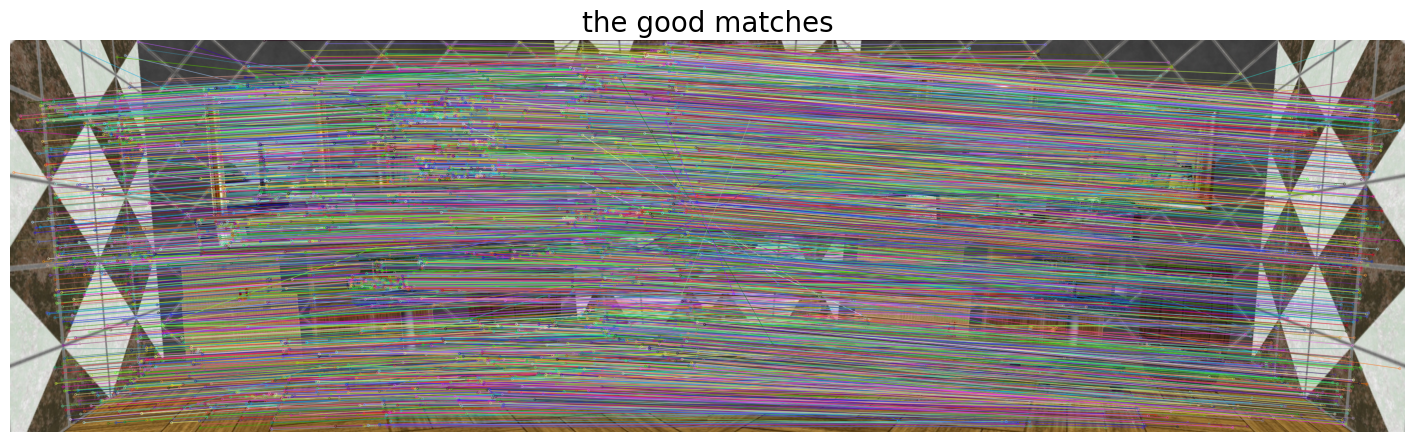

In [6]:
# Draw matches
img_matches = np.empty((max(left.shape[0], right.shape[0]), left.shape[1]+right.shape[1], 3), dtype=np.uint8)
matches_img = cv2.drawMatches(left, kp_left, right, kp_right, good_matches, img_matches, 
          flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(18,10))
plt.imshow(matches_img)
plt.axis('off')
plt.title('the good matches', fontsize=20)
plt.show()

## we compute the fundamental matrix from the matching keypoints

In [7]:
pts1 = np.int32(pts1)
pts2 = np.int32(pts2)

F, mask = cv2.findFundamentalMat(pts1,pts2,cv2.FM_LMEDS)
F, mask = cv2.findFundamentalMat(pts1,pts2,cv2.FM_LMEDS)
F, mask = cv2.findFundamentalMat(pts1,pts2,cv2.FM_LMEDS)
F, mask = cv2.findFundamentalMat(pts1,pts2,cv2.FM_LMEDS)
F, mask = cv2.findFundamentalMat(pts1,pts2,cv2.FM_LMEDS)

print(F)

[[ 7.74208072e-08  4.21630428e-07 -7.91132203e-04]
 [-4.21476040e-07  9.36662502e-08  5.56295963e-03]
 [-3.03627279e-04 -5.65272521e-03  1.00000000e+00]]


In [8]:
# We keep only inlier points
pts1 = pts1[mask.ravel()==1]
pts2 = pts2[mask.ravel()==1]

## Visualize epilines

In [9]:
# Adapted from: https://docs.opencv.org/master/da/de9/tutorial_py_epipolar_geometry.html
def drawlines(img1, img2, lines, pts1src, pts2src):
    # img1 - image on which we draw the epilines for the points in img2
    r, c ,_= img1.shape
    
    # use the same random seed so that two images are comparable!
    np.random.seed(0)
    
    for r, pt1, pt2 in zip(lines, pts1src, pts2src):
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0 = map(int, [0, -r[2]/r[1]])
        x1, y1 = map(int, [c, -(r[2]+r[0]*c)/r[1]])
        img1 = cv2.line(img1, (x0, y0), (x1, y1), color, 1)
        img1 = cv2.circle(img1, tuple(pt1), 5, color, 3)
        img2 = cv2.circle(img2, tuple(pt2), 5, color, 3)
    return img1, img2


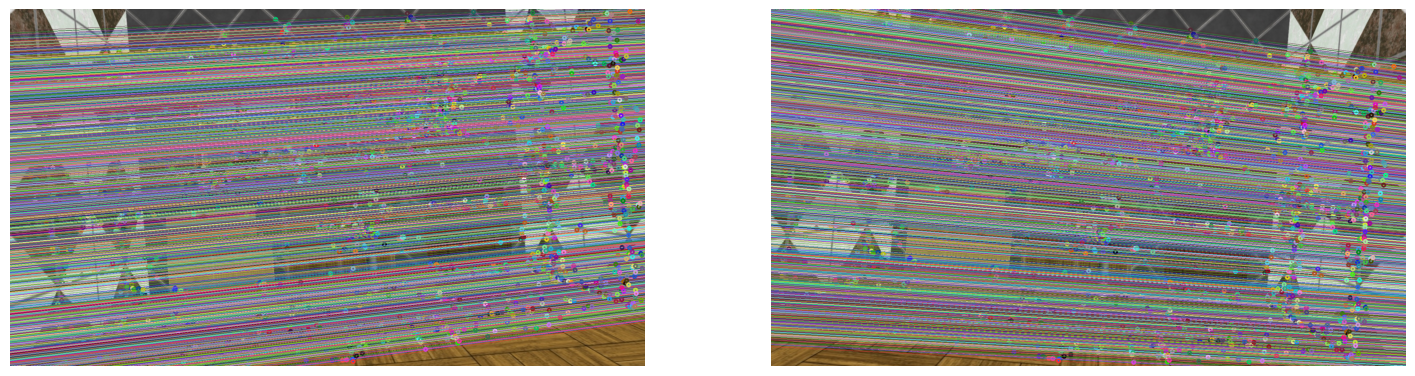

In [10]:
# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left image
lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1,1,2), 2,F)
lines1 = lines1.reshape(-1,3)
epi_left, _ = drawlines(np.copy(left),np.copy(right),lines1,pts1,pts2)

#Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1,1,2), 1,F)
lines2 = lines2.reshape(-1,3)
epi_right, _ = drawlines(np.copy(right),np.copy(left),lines2,pts2,pts1)


plt.figure(figsize=(18,10))
plt.subplot(121)
plt.imshow(epi_left)
plt.axis('off')
plt.subplot(122)
plt.imshow(epi_right)
plt.axis('off')
plt.show()

## warp images so that they correspond to simple stereo

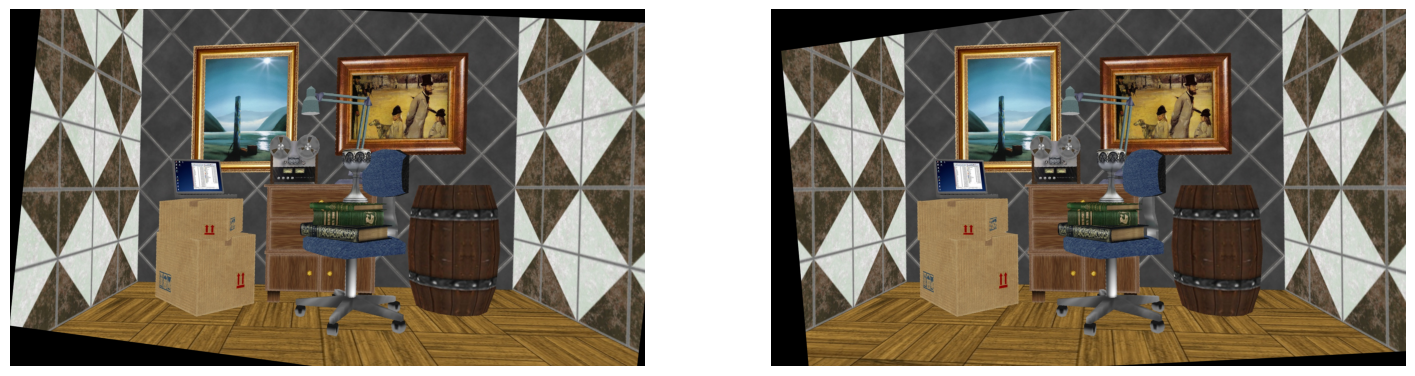

In [11]:
# Stereo rectification (uncalibrated variant)
# if we had calibrated cameras, we could use cv2.stereoRectify
# Adapted from: https://stackoverflow.com/a/62607343
h1, w1,_ = left.shape
h2, w2,_ = right.shape
_, H1, H2 = cv2.stereoRectifyUncalibrated(np.float32(pts1), np.float32(pts2), F, imgSize=(w1, h1))

# Undistort (rectify) the images 
left_rectified = cv2.warpPerspective(left, H1, (w1, h1))
right_rectified = cv2.warpPerspective(right, H2, (w2, h2))

# now epilines are horizontal and at the same height in both images

plt.figure(figsize=(18,10))
plt.subplot(121)
plt.imshow(left_rectified)
plt.axis('off')

plt.subplot(122)
plt.imshow(right_rectified)
plt.axis('off')

plt.show()

In [12]:
# replace images with rectified grayscale images
left = np.uint8(color.rgb2gray(left_rectified)*255)
right = np.uint8(color.rgb2gray(right_rectified)*255)

## compute disparity map

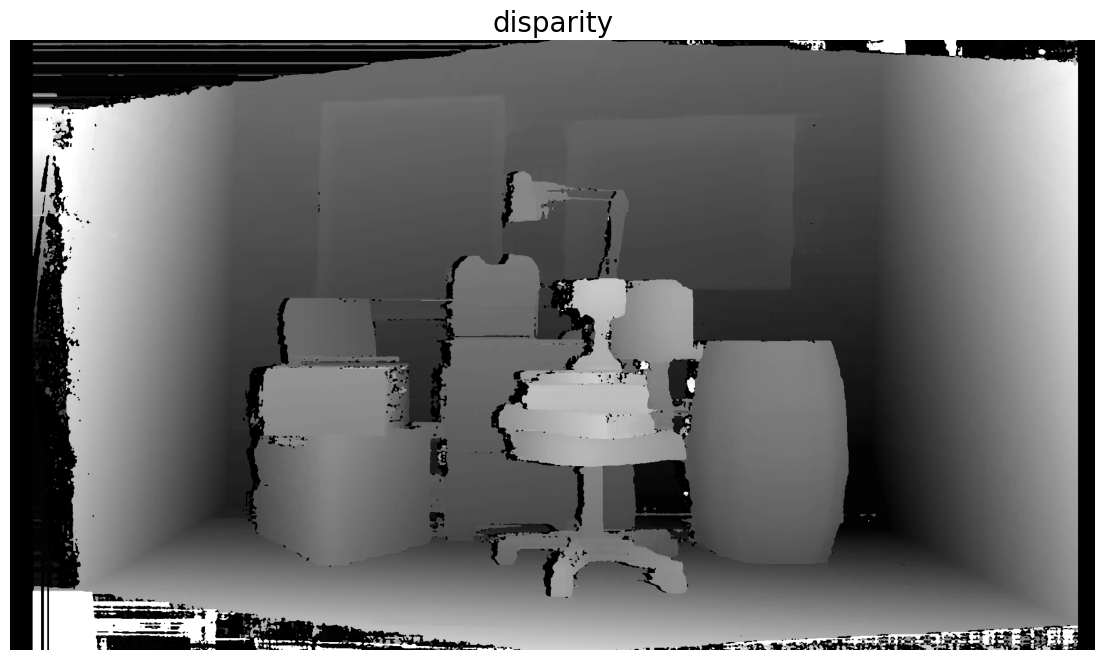

In [13]:
window_size = 5

# Creating an object of StereoSGBM algorithm
stereo = cv2.StereoSGBM_create(
        minDisparity = -30,              # minimum possible disparity
        numDisparities = 70,             # range of disparities
        blockSize = window_size,         # matchd block
        P1=8 * 3 * window_size ** 2,     # threshold controlling disparity smoothness
        P2=32 * 3 * window_size ** 2,    # threshold controlling disparity smoothness
        disp12MaxDiff =-1,               # an additional check, -1 is switched of
        uniquenessRatio = 5,             # percentage the best match needs to win over second to be considered correct
        speckleWindowSize = 0,           # speckle filtering based on region size, 0 means off
        speckleRange = 2,                # speckle filtering based on region size
        preFilterCap=0,
        mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY
    )
# Calculating disparity using the StereoSGBM algorithm
disp = stereo.compute(left, right).astype(np.float32)
#disp = cv2.normalize(disp,0,255,cv2.NORM_MINMAX)   # rescaling if depth range is small 

plt.figure(figsize=(14,9))
plt.imshow(disp, cmap= 'gray')
plt.axis('off')
plt.title('disparity', fontsize=20)

plt.show()